# DMRG: 1D Transverse Field Ising Model

In this quickstart guide, we apply pyTTN to evaluate the ground state energy of the 1D Transverse Field Ising model using a matrix product state representation for the wavefunction.  We consider the Hamiltonian

$$ \hat{H} = -J \displaystyle\sum_{j=1}^{N-1} \hat{\sigma}^z_j \hat{\sigma}^z_{j+1} + h \displaystyle\sum_j^N \hat{\sigma}^x_j$$

where we will consider the critical point, namely $J = 1$, $h=1$, and with $N=64$ spins.

### Contents


1. [Importing the Package](#importing-the-package)

2. [Setting up the System and Hamiltonian](#setting-up-the-system-and-hamiltonian)

3. [Preparing the Initial Wavefunction](#preparing-the-initial-wavefunction)

4. [Preparing the sop_operator Representation of the Hamiltonian](#preparing-the-sop_operator-hamiltonian)

5. [Setting up and Performing the DMRG Loop](#setting-up-and-performing-the-dmrg-loop)


### Importing the Package

We start by importing the required modules for this example

In [1]:
import os
os.environ['OMP_NUM_THREADS']='1'

import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

import pyttn
from pyttn.utils import visualise_tree

### Setting up the System and Hamiltonian

We start by setting up the `system_modes` object that tells pyTTN the type of operators to expect, and local Hilbert space dimension associated with each mode.  For the case of the $N=64$ spin-$\frac{1}{2}$ system we are considering here.  This is done as follows:

In [2]:
# Define number of modes
N = 64

# Initialise system information variable as a set of N modes
sysinf = pyttn.system_modes(N)

# Specify that each mode is a two level system
for i in range(N):
    sysinf[i] = pyttn.tls_mode()

We now prepare the system Hamiltonian through the use of the `SOP` class.  This makes use of a string representation of the Hamiltonian, that is later converted into a form necessary for performing calculations.  For more details on the generation of operators see the [tutorial on operator generation](file/../operator_generation.ipynb).

In [ ]:
J = 1.0
h = 1.0

#set up the system Hamiltonian
H = pyttn.SOP(N)

#add on the onsite transversal fields
for i in range(N):
    H += h*pyttn.sOP("sx", i)

#now add on the zz interactions
for i in range(N-1):
    H += -J*pyttn.sOP("sz", i)*pyttn.sOP("sz", i+1)

### Preparing the Initial Wavefunction

We now prepare the initial wavefunction.  This requires a two-step process, first we define the tree topology to use for this calculation through the use of the `ntree` class (which for this example we choose to be an MPS), following which we construct the `ttn` object that actually represents the wavefunction.  In this example we intend to use a subspace expansion based in order to expand bond dimension throughout the DMRG loop.  In order to do this, we define an additional `ntree` object with the same structure but different values defining the maximum allowed dimension of any bond in the network.  For more details one the construct of tree topologies see the [tutorial on tree topologies](file/../tree_topologies.ipynb). 


In [4]:
# Initial bond dimension
chi = 4

#maximum bond dimension
chi_max = 32

# Vector of dimensions of the local Hilbert space in the physical nodes
dims = sysinf.mode_dimensions()

#now construct an ntree object storing the MPS topology using the ntreeBuilder class
topo = pyttn.ntreeBuilder.mps_tree(dims, chi)
capacity = pyttn.ntreeBuilder.mps_tree(dims, chi_max)

#now allocate the wavefunction object.  And allocate it so that each tensor is filled with random values
A = pyttn.ttn(topo, capacity, dtype=np.complex128)
A.random()

When creating the `ttn` object, tensors will be constructed with the sizes defined in `topo` but with enough space allocated to store the tensors defined in `capacity`.  

### Preparing the `sop_operator` Hamiltonian

Now before we are ready to set up and perform the DMRG loop, we first need to convert the Hamiltonian into a form that can be used to efficiently within the DMRG algorithm.  Within pyTTN, two formats are supported for the Hamiltonian:

1. the Sum-of-Product operator representation
2. the Hierarchical Sum-of-Product operator representation 

With the Sum-of-Product operator representation being the standard form used in ML-MCTDH calculations and the Hierarchical Sum-of-Product operator representation being equivalent to a sparse tensor representation of a Tree Tensor Network Operator.  Within pyTTN, both types of operator are handled with the same objects, namely the `sop_operator`.  The user can select between these two operator representations through the use of the compress variable with:

- `compress=False` leading to the construction of a Sum-of-Product operator
- `compress=True` leading to the construction of a Hierarchical Sum-of-Product operator.

By default calls to `sop_operator` will lead to the construction of Hierarchical Sum-of-Product operators.

In [5]:
h = pyttn.sop_operator(H, A, sysinf, compress=True)

### Setting up and Performing the DMRG Loop

Now we can have everything we need to set up all of the objects required to perform the DMRG loop.  Here we set up DMRG with the use of subspace expansion to expand bond dimensions throughout the update steps. 

In [6]:
#set up the DMRG sweeping object to 
sweep = pyttn.dmrg(A, h, krylov_dim = 4, expansion='subspace', subspace_krylov_dim=12, subspace_neigs=6)

#set up the subspace expansion parameters.  Here we expand bond dimension whenever a term in the 
#two-site energy variance (that is not captured within the single-site spaces) has singular value > 1e-5, 
#and do not use natural populations to determine whether to spawn additional basis functions.
sweep.spawning_threshold = 1e-10
sweep.minimum_unoccupied=0

Now we have everything needed to perform the DMRG loop.  Here we perform 10 steps and plot the energy per spin for each step in the DMRG sweep:

In [7]:
for i in range(10):
    #perform the DMRG step
    sweep(A, h)

    #and print out the energy per spin, and maximum bond dimension of the A tensor for the sweep
    print(i+1, np.real(sweep.E()/N), A.maximum_bond_dimension())


1 -1.2675382099057548 13
2 -1.267593435039451 20
3 -1.2675934393941446 24
4 -1.2675934394149269 24
5 -1.2675934394162052 24
6 -1.2675934394163335 24
7 -1.2675934394163881 24
8 -1.2675934394164143 24
9 -1.2675934394164239 24
10 -1.2675934394164328 24


Here we observe convergence of the result to the expected value of:

In [8]:
E = (1 - 1/np.sin(np.pi/(2*(2*N+1))))
print(E/N)

-1.2675934394241177


Now finally, we will visualise what the subspace expansion scheme has done to the bond dimension of the TTN, using the `visualise_tree` function.

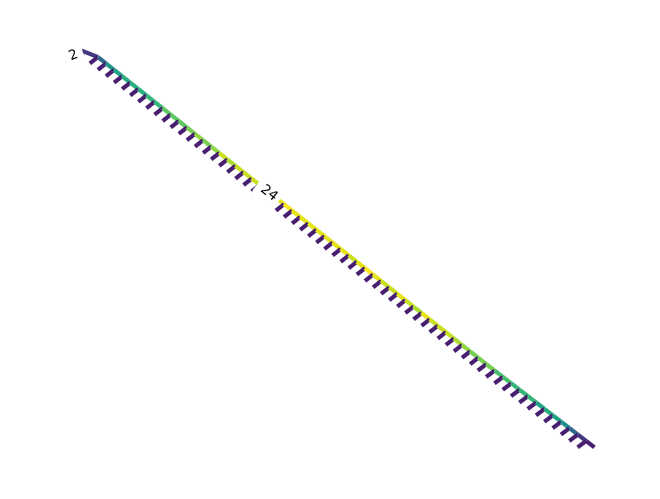

In [9]:
visualise_tree(A, bond_prop="bond dimension", node_size=0)
plt.show()